In [3]:
%%capture
# Install the transformers library
!pip install datasets transformers==4.28.0
!pip install --upgrade accelerate

In [4]:
# Import required packages
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts

    def __len__(self):
        return len(self.tokenized_texts["input_ids"])

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}

In [5]:
# Load tokenizer and model, create trainer
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

In [6]:
rev_apple = pd.read_csv("https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/Revolut_apple.csv")
rev_play = pd.read_csv("https://raw.githubusercontent.com/HaoEarm/DSA3101_Project/main/Data/revolut_play_df.csv")
rev_all = pd.concat([rev_apple, rev_play], ignore_index= True)
rev_all = rev_all.drop(columns=['Unnamed: 0'])
rev_all['No.'] = rev_all.reset_index().index

In [7]:
# Tokenize texts and create prediction data set
tokenized_texts = tokenizer(list(rev_all['Review']),truncation=True,padding=True)
pred_dataset = SimpleDataset(tokenized_texts)

In [8]:
# Run predictions
predictions = trainer.predict(pred_dataset)

In [9]:
# Transform predictions to labels
preds = predictions.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)

In [10]:
# Create DataFrame with texts, predictions, labels, and scores
df = pd.DataFrame(list(zip(rev_all['Review'],preds,labels,scores)), columns=['Review','pred','label','score'])
print(df.columns)
print(rev_all.columns)

Index(['Review', 'pred', 'label', 'score'], dtype='object')
Index(['UserName', 'Review', 'Score', 'Date', 'Bank', 'No.'], dtype='object')


In [11]:
merged_df = pd.merge(rev_all, df, on='Review', how='inner')
merged_df

,UserName,Review,Score,Date,Bank,No.,pred,label,score
0,steveawsum,"I signed up, completed identity verification a...",1,2024-03-08 05:51:31,Revolut,0,0,NEGATIVE,0.999510
1,AlvaroAW,While the rest of the banks make it more diffi...,5,2024-03-08 02:33:09,Revolut,1,1,POSITIVE,0.998870
2,channa_e,I was subscribed to metal and I wanted to clos...,1,2024-03-03 15:05:39,Revolut,2,0,NEGATIVE,0.999489
3,DavidChing,Had issue signing up twice. Go back to YouTrip,1,2024-03-03 13:18:10,Revolut,3,0,NEGATIVE,0.999442
4,Perry-the-Platypus,What a joke of an app that tries to help excha...,1,2024-03-01 10:06:53,Revolut,4,0,NEGATIVE,0.999504
...,...,...,...,...,...,...,...,...,...
875,Anoop Jacob,Good experience,5,2024-03-22 18:58:22,Revolut,668,1,POSITIVE,0.998830
876,Tony Milroy,"Terrible, just get to document upload process ...",1,2024-03-22 18:44:36,Revolut,669,0,NEGATIVE,0.999506
877,Mary O Hare,Happy with service,4,2024-03-22 18:42:50,Revolut,670,1,POSITIVE,0.998885
878,Kenneth Eagling,I would refer you to Dr. RANCOURT who showed i...,5,2024-03-22 18:41:42,Revolut,671,1,POSITIVE,0.990289


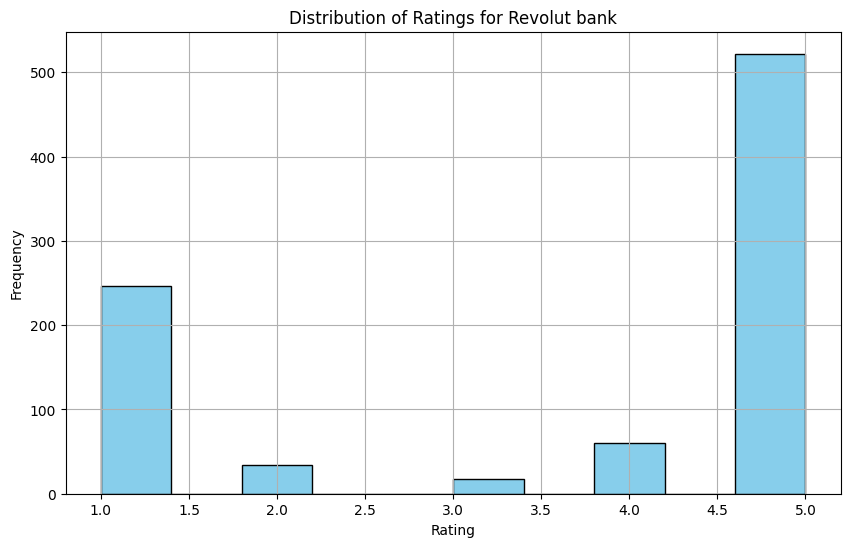

In [12]:
import matplotlib.pyplot as plt
# Plot histogram of polarity scores
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Score'], color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings for Revolut bank')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

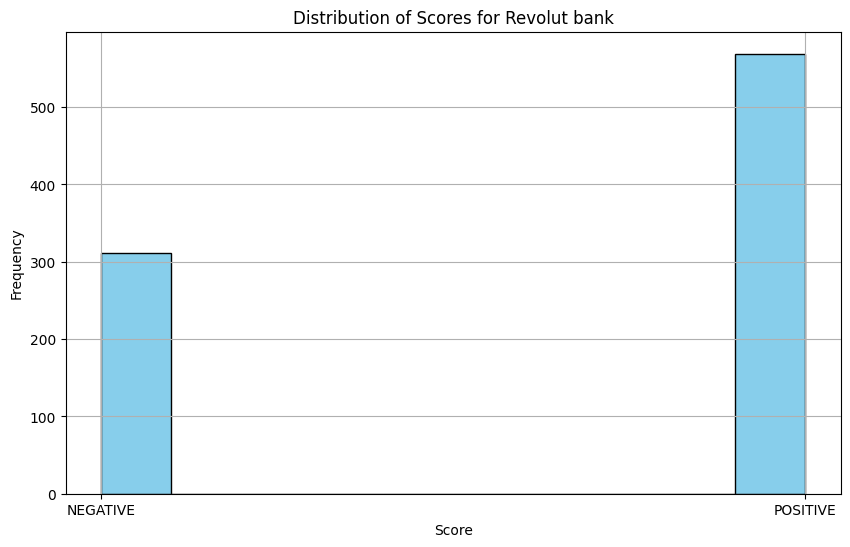

In [13]:
import matplotlib.pyplot as plt
# Plot histogram of polarity scores
plt.figure(figsize=(10, 6))
plt.hist(merged_df['label'], color='skyblue', edgecolor='black')
plt.title('Distribution of Scores for Revolut bank')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The sentiments are accurately captured by the model when we base it on reviews

In [14]:
conditions = [
    (merged_df['Score'] <= 2),
    (merged_df['Score'] == 3 ),
    (merged_df['Score'] >= 4)
]

values = ['Detractor', 'Passive', 'Promoter']

merged_df['NPS category'] = np.select(conditions, values)
print(merged_df.head())

             UserName                                             Review  \
0          steveawsum  I signed up, completed identity verification a...   
1            AlvaroAW  While the rest of the banks make it more diffi...   
2            channa_e  I was subscribed to metal and I wanted to clos...   
3          DavidChing     Had issue signing up twice. Go back to YouTrip   
4  Perry-the-Platypus  What a joke of an app that tries to help excha...   

   Score                 Date     Bank  No.  pred     label     score  \
0      1  2024-03-08 05:51:31  Revolut    0     0  NEGATIVE  0.999510   
1      5  2024-03-08 02:33:09  Revolut    1     1  POSITIVE  0.998870   
2      1  2024-03-03 15:05:39  Revolut    2     0  NEGATIVE  0.999489   
3      1  2024-03-03 13:18:10  Revolut    3     0  NEGATIVE  0.999442   
4      1  2024-03-01 10:06:53  Revolut    4     0  NEGATIVE  0.999504   

  NPS category  
0    Detractor  
1     Promoter  
2    Detractor  
3    Detractor  
4    Detractor  


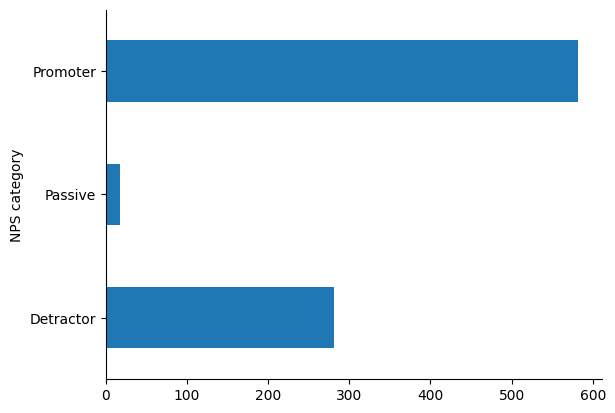

In [17]:
merged_df.groupby('NPS category').size().plot(kind='barh')
plt.gca().spines[['top', 'right',]].set_visible(False)